In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self,other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.grad * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in graph, create reactangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

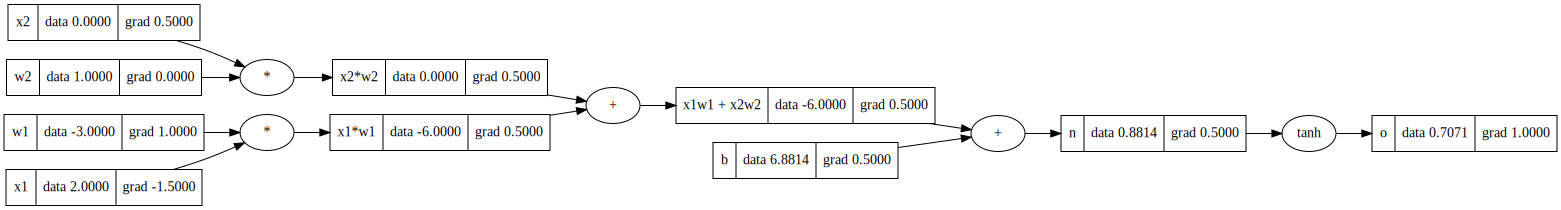

In [ ]:
draw_dot(o)

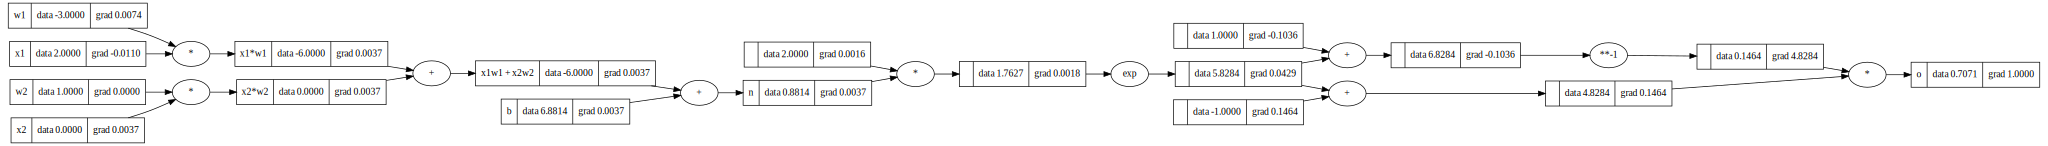

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ------
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad =  True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
-----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
import random

class Neuron():

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.0955346384483344)

In [ ]:
n.parameters()

[Value(data=0.1817230509298291),
 Value(data=-0.6352825676895251),
 Value(data=-0.3494176507825155),
 Value(data=0.9433099024256493),
 Value(data=0.3284092021884346),
 Value(data=0.816726699781867),
 Value(data=-0.0625288531638104),
 Value(data=-0.07397234989070856),
 Value(data=0.961326872135573),
 Value(data=-0.058523048770034336),
 Value(data=0.7924332648018755),
 Value(data=0.47807946088506426),
 Value(data=0.3310617423072517),
 Value(data=0.36040656673145555),
 Value(data=-0.657607430340684),
 Value(data=0.3049757728710776),
 Value(data=-0.12597873957702688),
 Value(data=0.9221161995755947),
 Value(data=0.5378174929828501),
 Value(data=-0.3386608279745378),
 Value(data=-0.7962218438491542),
 Value(data=0.5404814304700372),
 Value(data=0.3953081902079296),
 Value(data=0.9436733790545446),
 Value(data=0.06878959256000483),
 Value(data=-0.5604531154793784),
 Value(data=0.4359570220234579),
 Value(data=-0.2715346921934103),
 Value(data=0.2373827429345956),
 Value(data=-0.3513896132448

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.0955346384483344),
 Value(data=0.7333300725068016),
 Value(data=0.2880385186199652),
 Value(data=0.5061426680288885)]

In [ ]:
for k in range(30):
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)), start=(Value(0.0)))

  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  for p in n.parameters():
    p.data += -0.05 * p.grad
  print(k, loss.data)

0 1.015793106176461e-10
1 1.015793105765026e-10
2 1.0157931053535911e-10
3 1.0157931049421562e-10
4 1.0157931045307212e-10
5 1.0157931041192862e-10
6 1.0157931037078512e-10
7 1.0157931032964162e-10
8 1.0157931028849814e-10
9 1.0157931024735464e-10
10 1.0157931020621114e-10
11 1.0157931016506764e-10
12 1.0157931012392414e-10
13 1.0157931008278064e-10
14 1.0157931004163715e-10
15 1.015793099989112e-10
16 1.015793099577677e-10
17 1.015793099166242e-10
18 1.015793098754807e-10
19 1.0157930983275477e-10
20 1.0157930979161127e-10
21 1.0157930975046779e-10
22 1.0157930970932429e-10
23 1.0157930966818079e-10
24 1.0157930962703729e-10
25 1.015793095858938e-10
26 1.015793095447503e-10
27 1.015793095036068e-10
28 1.015793094624633e-10
29 1.015793094213198e-10


In [ ]:
ypred

[Value(data=0.9999928733139029),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=0.9999928733139052)]